In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.distributed import Dataset
import cv2 
import re
from PIL import Image


In [2]:
import zipfile
with zipfile.ZipFile('/content/cell-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('cell_dataset')

BATCH_SIZE = 32
TRAIN_SIZE = 150

In [3]:
images_list = os.listdir('/content/cell_dataset/data/images/')
images_list = sorted(images_list)

In [4]:
class CellDataset(Dataset):

  def __init__(self, root_path, images_list, x_images_dir='images', transform=None):
    self.root_path = root_path
    self.images = images_list
    self.x_images_dir = x_images_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.images)

  @property
  def targets(self):
    targets = [self.__getitem__(i)[1] for i in range(len(self.images))]
    return targets

  def __getitem__(self, idx):
    image_filename = self.images[idx]
    label_file_name = image_filename.replace('cell', 'dots')

    x_path = os.path.join(self.root_path, self.x_images_dir, image_filename)
    y_path = os.path.join(self.root_path, 'labels', label_file_name)

    image = cv2.imread(x_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = cv2.imread(y_path) 
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)[:,:,0].sum() / 255
    
    if self.transform is not None:
      image = self.transform(image)
    
    return image, label

# image visualization

In [5]:
dataset = CellDataset(root_path='/content/cell_dataset/data/',
                            images_list=images_list,
                            transform= transforms.Compose([transforms.ToTensor()]))


image_data_loader = DataLoader(
  dataset, 
  # batch size is whole datset
  batch_size=len(dataset), 
  shuffle=False, 
  num_workers=0)

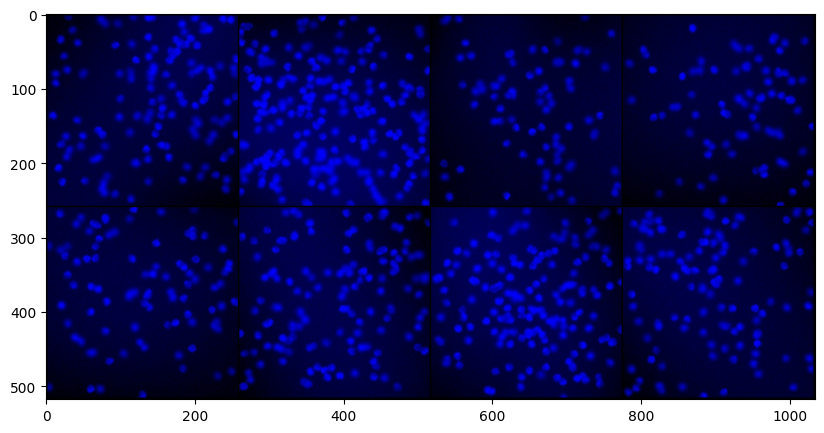

In [6]:
def imshow(img, title=None):
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5), dpi=100)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(image_data_loader))
inputs = inputs[0:8]
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out)

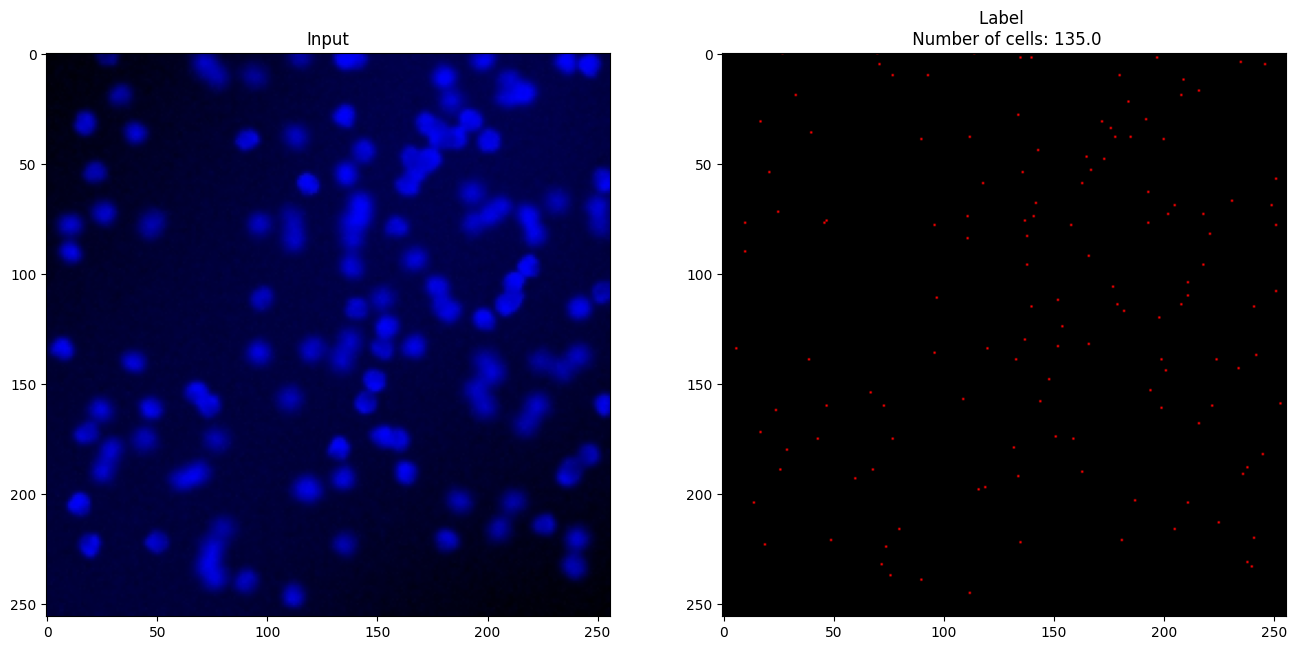

In [7]:
from google.colab.patches import cv2_imshow


input_image = '/content/cell_dataset/data/images/001cell.png'
label_image = '/content/cell_dataset/data/labels/001dots.png'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
plt.subplot(1,2,1)
input_image = cv2.imread(input_image)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
plt.imshow(input_image)
axes[0].set_title("Input")
plt.subplot(1,2,2)
label_image = cv2.imread(label_image)
label_image = cv2.cvtColor(label_image, cv2.COLOR_BGR2RGB)
cells = label_image[:,:, 0].sum() / 255
plt.imshow(label_image)
axes[1].set_title(f"Label \n Number of cells: {cells}");

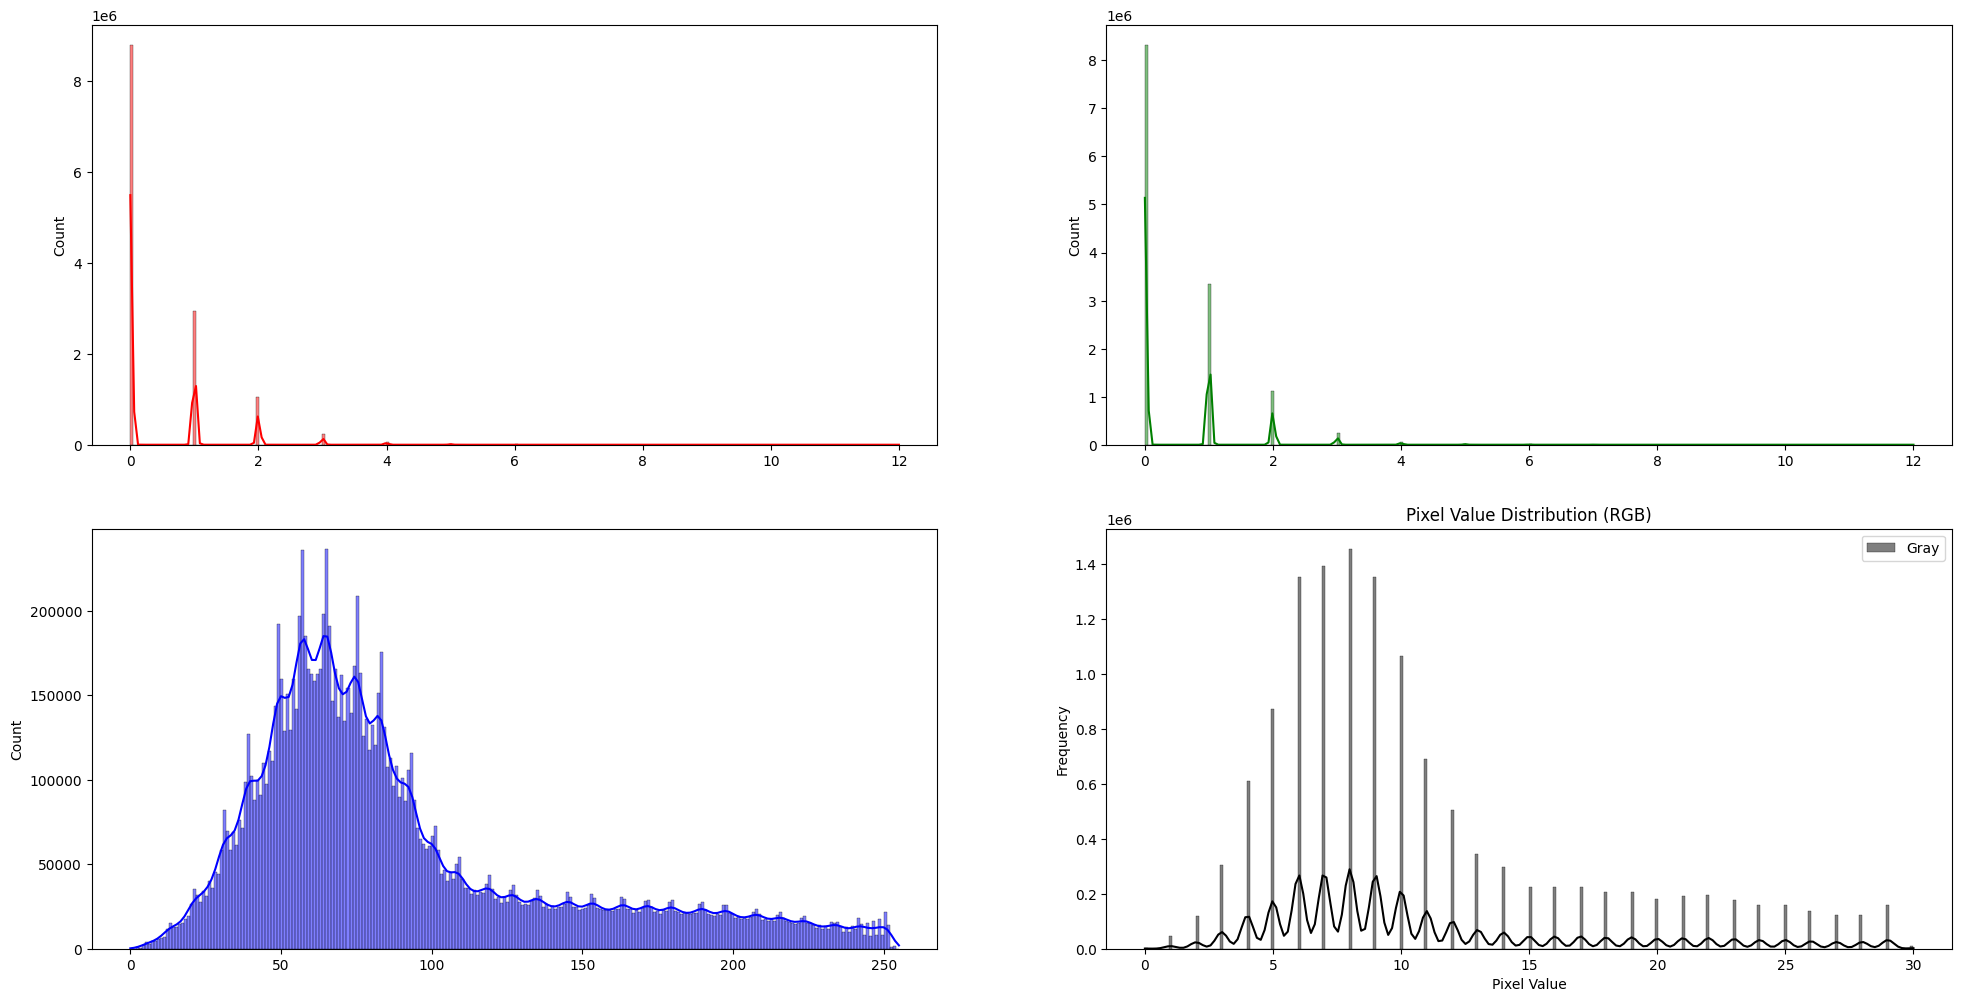

In [8]:

fig, axes = plt.subplots(2,2, figsize=(24,12))

# Directory containing the images
image_dir = "/content/cell_dataset/data/images"

# Lists to store pixel values for each color channel
pixel_values_r = []
pixel_values_g = []
pixel_values_b = []
pixel_values_gray = []

# Loop through the images in the directory
for filename in os.listdir(image_dir):
    if  filename.endswith(".png"):  # You can modify this condition to filter image file types
        # Read the image using OpenCV
        img = cv2.imread(os.path.join(image_dir, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Split the image into color channels
        img_r, img_g, img_b = cv2.split(img)
        # Flatten the pixel values arrays and append to the respective lists
        pixel_values_r.extend(img_r.flatten())
        pixel_values_g.extend(img_g.flatten())
        pixel_values_b.extend(img_b.flatten())
        pixel_values_gray.extend(img_gray.flatten())

# Plot the pixel value distributions for each color channel
plt.subplot(2,2,1)
sns.histplot(pixel_values_r, bins=256, kde=True, color='r', label='Red')

plt.subplot(2,2,2)
sns.histplot(pixel_values_g, bins=256, kde=True, color='g', label='Green')

plt.subplot(2,2,3)
sns.histplot(pixel_values_b, bins=256, kde=True, color='b', label='Blue')

plt.subplot(2,2,4)
sns.histplot(pixel_values_gray, bins=256, kde=True, color='black', label='Gray')

plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Pixel Value Distribution (RGB)")
plt.legend()
plt.show()

## Data Preprocessing

Expand dataset by augmentations.

In [9]:
! rm -r '/content/cell_dataset/data/train'

In [10]:
if not os.path.exists('/content/cell_dataset/data/train'):
  os.mkdir(os.path.join('/content/cell_dataset/data', 'train'))
  os.mkdir(os.path.join('/content/cell_dataset/data/train', 'images'))
  os.mkdir(os.path.join('/content/cell_dataset/data/train', 'labels'))

  hflipper = transforms.Compose([
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(p=1)
      ])

  vflipper = transforms.Compose([
      transforms.ToTensor(),
      transforms.RandomVerticalFlip(p=1)
  ])

  transformers = [('hf', hflipper), ('vf', vflipper)]

  pil_transformer = transforms.ToPILImage()

  for index in range(TRAIN_SIZE):
    image_path = images_list[index]                      
    label_file_name = image_path.replace('cell', 'dots')
    x_path = os.path.join('/content/cell_dataset/data', 'images', image_path)
    y_path = os.path.join('/content/cell_dataset/data', 'labels', label_file_name)

    image = Image.open(x_path) 
    label =  Image.open(y_path)
    train_path = os.path.join('/content/cell_dataset/data/train/images/', image_path)
    labels_path = os.path.join('/content/cell_dataset/data/train/labels/', label_file_name)
    image.save(train_path)
    label.save(labels_path)
    for transformer in transformers:
      image_trans = transformer[1](image)
      label_trans = transformer[1](label)
      train_path = os.path.join('/content/cell_dataset/data/train/images/', f'{transformer[0]}_{image_path}')
      labels_path = os.path.join('/content/cell_dataset/data/train/labels/', f'{transformer[0]}_{label_file_name}')
      pil_transformer(image_trans).save(train_path)
      pil_transformer(label_trans).save(labels_path)

In [11]:
train_images_list = os.listdir('/content/cell_dataset/data/train/images/')
train_images_list = sorted(train_images_list)

In [12]:
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.0018, 0.0020, 0.3545]) tensor([0.0031, 0.0032, 0.2067])


In [13]:
transforms_aug = transforms.RandomChoice([transforms.RandomHorizontalFlip(p=1),
                                          transforms.RandomVerticalFlip(p=1)
                                          ])

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # transforms_aug,
        transforms.Normalize(mean=mean, std=std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
}

train_dataset = CellDataset(root_path='/content/cell_dataset/data/train/',
                            images_list=train_images_list,
                            transform=data_transforms['train'])

validation_dataset =  CellDataset(root_path='/content/cell_dataset/data/',
                            images_list=images_list[TRAIN_SIZE:],
                            transform=data_transforms['val'])

image_datasets = {'train': train_dataset,
                  'val': validation_dataset}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=2),
               
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
  }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 450, 'val': 50}


# U-Net model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
class Encoder(nn.Module):

  def __init__(self, c_in, c_out):
    super(Encoder, self).__init__()
    self.conv_results = None
    self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=(3,3), stride=1, padding=1)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=(3,3), padding=1)
    self.batch_norm = nn.BatchNorm2d(c_out)
    self.act2 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

  def forward(self, x):
    # first_direction
    x = self.act1(self.conv1(x))
    x = self.act2(self.batch_norm(self.conv2(x)))
    self.conv_results = x.clone()
    x = self.pool(x)
    return x

class Decoder(nn.Module):

  def __init__(self, c_in, c_out):
    super(Decoder, self).__init__()
    self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=(3,3), stride=1, padding=1)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=(3,3), stride=1, padding=1)
    self.batch_norm = nn.BatchNorm2d(c_out)
    self.act2 = nn.ReLU()

  def forward(self, x):
    # first_direction
      x = self.act1(self.conv1(x))
      x = self.act2(self.batch_norm(self.conv2(x)))
      return x


class UNet(nn.Module):
    def __init__(self, c_in=3, base_filters=64):
        super(UNet, self).__init__()

        self.encoder1 = Encoder(c_in=c_in, c_out=base_filters)
        self.encoder2 = Encoder(c_in=base_filters, c_out=base_filters*2)
        self.encoder3 = Encoder(c_in=base_filters*2, c_out=base_filters*4)
        self.encoder4 = Encoder(c_in=base_filters*4, c_out=base_filters*8)

        self.ct1 = nn.ConvTranspose2d(base_filters*8, base_filters*8, kernel_size=(2, 2), stride=(2, 2))
        self.decoder1 = Decoder(c_in=base_filters*16, c_out=base_filters*8)
        self.ct2 =  nn.ConvTranspose2d(base_filters*8, base_filters*4, kernel_size=(2, 2), stride=(2, 2))
        self.decoder2 = Decoder(c_in=base_filters*8, c_out=base_filters*4)
        self.ct3 =  nn.ConvTranspose2d(base_filters*4, base_filters*2, kernel_size=(2, 2), stride=(2, 2))
        self.decoder3 = Decoder(c_in=base_filters*4, c_out=base_filters*2)
        self.ct4 =  nn.ConvTranspose2d(base_filters*2, base_filters, kernel_size=(2, 2), stride=(2, 2))
        self.decoder4 = Decoder(c_in=base_filters*2, c_out=base_filters)
        self.conv1x1 = nn.Conv2d(base_filters, 1, kernel_size=(1,1))
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(65536, 1)
        

    def forward(self, x):
      # first_direction
        x = self.encoder1.forward(x)
        x = self.encoder2.forward(x)
        x = self.encoder3.forward(x)
        x = self.encoder4.forward(x)

        x = self.ct1(x)
        x = torch.cat([x, self.encoder4.conv_results], 1)
        x = self.decoder1.forward(x)
        x = self.ct2(x)
        x = torch.cat([x, self.encoder3.conv_results], 1)
       
        x = self.decoder2.forward(x)
        x = self.ct3(x)
        x = torch.cat([x, self.encoder2.conv_results], 1)
        x = self.decoder3.forward(x)
        x = self.ct4(x)
        x = torch.cat([x, self.encoder1.conv_results], 1)
        x = self.decoder4.forward(x)
        x = self.conv1x1(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

# Train model

In [16]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs).squeeze().to(torch.float64)
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            dict_res[phase][0,epoch]= epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best loss {round(best_loss, 4)}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

In [21]:
model = UNet(c_in=3, base_filters=32)

from torchsummary import summary
summary(model.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,248
       BatchNorm2d-4         [-1, 32, 256, 256]              64
              ReLU-5         [-1, 32, 256, 256]               0
         MaxPool2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
              ReLU-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,928
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]          73,856
             ReLU-14          [-1, 128,

In [18]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [22]:
# If a GPU is available, make the model use it
torch.cuda.empty_cache()
model = model.to(device)
lr=0.0004

criterion = RMSELoss
optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=7e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.2)

num_epochs = 30

model,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 102.1982
val Loss: 174.2761

Epoch 1/29
----------
train Loss: 15.4433
val Loss: 121.1847

Epoch 2/29
----------
train Loss: 13.0478
val Loss: 45.2650

Epoch 3/29
----------
train Loss: 10.2807
val Loss: 28.5512

Epoch 4/29
----------
train Loss: 9.4472
val Loss: 39.7033

Epoch 5/29
----------
train Loss: 9.4023
val Loss: 5.4855

Epoch 6/29
----------
train Loss: 8.6630
val Loss: 16.6691

Epoch 7/29
----------
train Loss: 5.7745
val Loss: 11.4894

Epoch 8/29
----------
train Loss: 5.5498
val Loss: 10.6983

Epoch 9/29
----------
train Loss: 5.3774
val Loss: 8.1493

Epoch 10/29
----------
train Loss: 5.1044
val Loss: 12.0270

Epoch 11/29
----------
train Loss: 4.9803
val Loss: 8.4515

Epoch 12/29
----------
train Loss: 4.7254
val Loss: 5.5339

Epoch 13/29
----------
train Loss: 4.4489
val Loss: 5.2921

Epoch 14/29
----------
train Loss: 4.5217
val Loss: 9.5925

Epoch 15/29
----------
train Loss: 3.7787
val Loss: 7.5398

Epoch 16/29
----------
train Loss:

# Model evaluations

In [23]:
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 1, figsize=(8,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])


def predict(model, dataloader):
  model.eval()
  predictions = []

  for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      predictions += outputs.flatten().tolist()
  return predictions


def plot_labels_vs_predictions(labels, predictions, color, label_name):
  sns.scatterplot(x=labels, y=predictions, color=color, label=label_name)
  plt.title(f'Labels vs Predictions ({label_name})');
  plt.legend()

<ipython-input-23-c77a098b1e68>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])


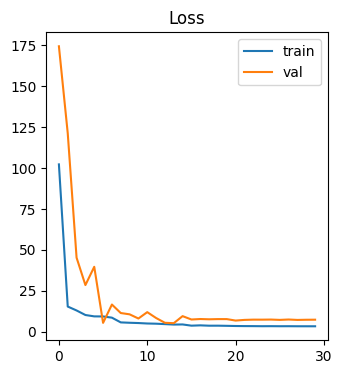

In [24]:
plot_convergence(dict_res,num_epochs ); plt.show();

In [25]:
from sklearn.metrics import mean_absolute_error

torch.cuda.empty_cache()

dataloaders_prediction = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=8,
                                             shuffle=False, num_workers=1),
               
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=8,
                                          shuffle=False, num_workers=1)
  }

train_predictions = predict(model, dataloaders_prediction['train'])
validation_predictions = predict(model, dataloaders_prediction['val'])

val_mae = mean_absolute_error(validation_dataset.targets, validation_predictions)
train_mae = mean_absolute_error(train_dataset.targets, train_predictions)

print(f"Train MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")

Train MAE: 4.124748331705729
Validation MAE: 3.8708016967773435


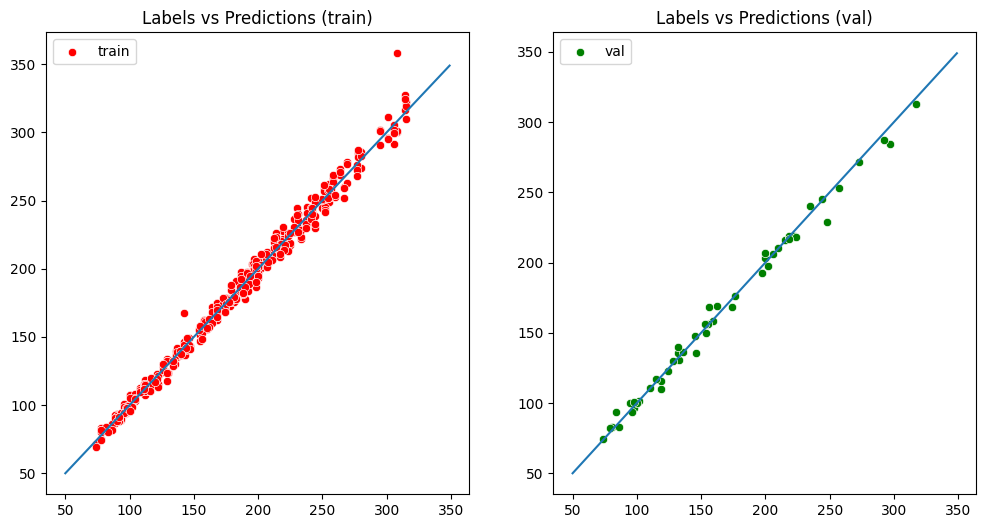

In [26]:

fig, axes = plt.subplots(1,2,figsize=(12,6))
line_plot_data = np.arange(50, 350)
plt.subplot(1,2,1)
plot_labels_vs_predictions(train_dataset.targets, train_predictions, 'r', 'train')
sns.lineplot(x=line_plot_data, y=line_plot_data)
plt.subplot(1,2,2)
plot_labels_vs_predictions(validation_dataset.targets, validation_predictions, 'g', 'val')
sns.lineplot(x=line_plot_data, y=line_plot_data);


In [27]:
test_dataset =  CellDataset(root_path='/content/cell_dataset/data/',
                            images_list=images_list[180:],
                            transform=data_transforms['val'])

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                             shuffle=False, num_workers=1)

test_predictions = predict(model, test_dataloader)

test_mae = mean_absolute_error(test_dataset.targets, test_predictions)

print(f"Test MAE: {test_mae}")



Test MAE: 4.9293212890625
